In [5]:
import dask.dataframe as dd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
#from data_preprocessing_pao import *

In [2]:
X_file = "data/X_matrix.csv"
Y_file = "data/y_phenotype.csv"

print("Loading the data...")
X = pd.read_csv(X_file)
Y = pd.read_csv(Y_file)

Loading the data...


In [14]:
# Ensure Yeast_ID is a string type
X['Yeast_ID'] = X['Yeast_ID'].astype(str)
Y['Yeast_ID'] = Y['Yeast_ID'].astype(str)

# Find the intersection of Yeast_ID in both files
common_yeasts = set(X['Yeast_ID']).intersection(set(Y['Yeast_ID']))

# Identify Yeast_IDs that are missing in each file
missing_in_X = set(Y['Yeast_ID']) - set(X['Yeast_ID'])
missing_in_Y = set(X['Yeast_ID']) - set(Y['Yeast_ID'])

# Print missing Yeast_IDs
if missing_in_X:
    print(f"Yeast_IDs missing in X: {len(missing_in_X)}")
else:
    print("No Yeast_IDs missing in X.")

if missing_in_Y:
    print(f"Yeast_IDs missing in Y: {len(missing_in_Y)}")
else:
    print("No Yeast_IDs missing in Y.")

# Filter to keep only the common Yeast_IDs
X_filtered = X[X['Yeast_ID'].isin(common_yeasts)].reset_index(drop=True)
Y_filtered = Y[Y['Yeast_ID'].isin(common_yeasts)].reset_index(drop=True)

# Ensure the Yeast_ID order matches in both files
X_filtered = X_filtered.sort_values(by="Yeast_ID").reset_index(drop=True)
Y_filtered = Y_filtered.sort_values(by="Yeast_ID").reset_index(drop=True)

# Check if Yeast_ID columns are in the same order
if all(X_filtered["Yeast_ID"] == Y_filtered["Yeast_ID"]):
    print("Yeast_IDs are aligned and in the same order.")
else:
    print("Error: Yeast_IDs are not aligned after filtering.")

# Display the dimensions of the filtered matrices
print(f"Dimensions de X_filtered: {X_filtered.shape}")
print(f"Dimensions de Y_filtered: {Y_filtered.shape}")

No Yeast_IDs missing in X.
No Yeast_IDs missing in Y.
Yeast_IDs are aligned and in the same order.
Dimensions de X_filtered: (792, 347953)
Dimensions de Y_filtered: (792, 2)


In [ ]:
# Vérification de l'ordre des Yeast_ID
print("Vérification de l'ordre des Yeast_ID...")
if not all(X["Yeast_ID"] == Y["Yeast_ID"]):
    raise ValueError("L'ordre des Yeast_ID ne correspond pas entre les deux fichiers.")

# Préparation des données
print("Préparation des données...")
X_data = X.drop(columns=["Yeast_ID"]).fillna(0)  # Remplacer les valeurs manquantes par 0 dans X
y_data = Y["YPD_doublingtime"].fillna(Y["YPD_doublingtime"].mean())  # Remplacer les valeurs manquantes par la moyenne dans Y

Vérification de l'ordre des Yeast_ID...
Préparation des données...
Division des données en ensemble d'entraînement et de test...
Dimensions de X_train: (633, 347952)
Dimensions de X_test: (159, 347952)
Dimensions de y_train: (633,)
Dimensions de y_test: (159,)


In [27]:
# %%
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD
import dask.dataframe as dd
from sklearn.preprocessing import MinMaxScaler

def scale_last_columns(data, num_mutations=341901):
    """
    Scales the last N columns (assumed to be CNVs) to a range of 0 to 1.
    
    Parameters:
        data (pd.DataFrame): x_train data
        num_last_columns (int): Number of copy number variation columns from the end to scale .

    Returns:
        pd.DataFrame: Data with the last columns scaled.
    """
    # Select the last N columns
    cnv_columns = data.iloc[:, num_mutations:]
    
    # Scale these columns
    scaler = MinMaxScaler()
    scaled_cnv = scaler.fit_transform(cnv_columns)
    
    # Replace the last N columns with their scaled values
    data.iloc[:, num_mutations:] = scaled_cnv
    
    return data


def remove_low_variance_features_last_columns(data, num_mutations=341901, threshold=0.05):
    """
    Removes features with variance below a specified threshold in the last N columns.
    This has been done already for mutations during our extraction of data, so it is only useful to do it for the copy number variation columns.
    
    Parameters:
        data (pd.DataFrame): Input data.
        num_mutations (int): Number of mutations to not apply variance filtering.
        threshold (float): Minimum variance a feature must have to be retained.

    Returns:
        pd.DataFrame: Data with low-variance features removed in the last N columns.
    """
    # Select the last N columns
    target_columns = data.iloc[:, num_mutations:]
    
    # Apply VarianceThreshold to these columns
    selector = VarianceThreshold(threshold=threshold)
    reduced_data = selector.fit_transform(target_columns)
    
    # Get the selected column indices
    selected_columns = target_columns.columns[selector.get_support()]
    
    # Ensure new DataFrame has the correct index
    reduced_data_df = pd.DataFrame(reduced_data, columns=selected_columns, index=target_columns.index)
    
    # Replace the last N columns with the reduced set
    data = pd.concat([data.iloc[:, :num_mutations], reduced_data_df], axis=1)
    
    return data


def apply_pca_last_columns(data, num_mutations=341901, n_components=0.95, normalize=True):
    """
    Applies PCA to reduce dimensionality of the last N columns of the dataset.
    
    Parameters:
        data (pd.DataFrame): Input data.
        num_last_columns (int): Number of columns from the end to apply PCA.
        n_components (float or int): Number of components to keep or the amount of variance to retain.

    Returns:
        pd.DataFrame: Data with PCA applied to the last N columns.
    """
    # Separate the last N columns and the rest of the dataset
    other_columns = data.iloc[:, :num_mutations]
    target_columns = data.iloc[:, num_mutations:]
    
    # Apply PCA to the last N columns
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(target_columns)

    # Normalize the PCA-transformed features if specified
    if normalize:
        scaler = MinMaxScaler()
        reduced_data = scaler.fit_transform(reduced_data)
    
    # Create a new DataFrame for the reduced PCA data
    reduced_columns = [f'PCA_{i+1}' for i in range(reduced_data.shape[1])]
    reduced_df = pd.DataFrame(reduced_data, columns=reduced_columns, index=data.index)
    
    # Concatenate the other columns with the reduced PCA columns
    result = pd.concat([other_columns, reduced_df], axis=1)
    
    return result


def metrics(x_train, x_train_preprocessed):
    """
    Compute and display various metrics for the original and preprocessed data.
    
    Parameters:
        x_train (pd.DataFrame): Original data.
        x_train_preprocessed (pd.DataFrame): Preprocessed data.
    """
    # Compute and print dimensions
    print("Dimensions of the DataFrame (original):", x_train.shape)
    print("Dimensions of the DataFrame (after preprocessing):", x_train_preprocessed.shape)

    # Exclude the first row and column for calculations
    x_cut = x_train.iloc[1:, 1:]
    x_cut_p = x_train_preprocessed.iloc[1:, 1:]

    # Compute and print mean
    mean_value_x_train = x_cut.values.mean()
    mean_value_x_train_preprocessed = x_cut_p.values.mean()
    print("\nMean of all values (original):", mean_value_x_train)
    print("Mean of all values (after preprocessing):", mean_value_x_train_preprocessed)

    # Compute and print max and min
    max_value_x_train = np.max(x_cut.values)
    min_value_x_train = np.min(x_cut.values)
    max_value_x_train_preprocessed = np.max(x_cut_p.values)
    min_value_x_train_preprocessed = np.min(x_cut_p.values)
    print("\nMax value (original):", max_value_x_train, "Min value (original):", min_value_x_train)
    print("Max value (after preprocessing):", max_value_x_train_preprocessed, "Min value (after preprocessing):", min_value_x_train_preprocessed)

    # Compute and print standard deviation
    std_x_train = x_cut.values.std()
    std_x_train_preprocessed = x_cut_p.values.std()
    print("\nStandard deviation (original):", std_x_train)
    print("Standard deviation (after preprocessing):", std_x_train_preprocessed)

    # Compute and print variance
    var_x_train = x_cut.values.var()
    var_x_train_preprocessed = x_cut_p.values.var()
    print("\nVariance (original):", var_x_train)
    print("Variance (after preprocessing):", var_x_train_preprocessed)

def preprocessed_data (x_df, y_df) :
    x_train_scaled = scale_last_columns(x_df)
    x_train_lv = remove_low_variance_features_last_columns(x_train_scaled)
    x_train = apply_pca_last_columns(x_train_lv)

    return x_train, y_df

In [36]:
X_data_f, y_data_f = preprocessed_data(X_data, y_data)

In [37]:
metrics(X_data,X_data_f)

Dimensions of the DataFrame (original): (792, 347952)
Dimensions of the DataFrame (after preprocessing): (792, 341965)

Mean of all values (original): 0.031414799995161016
Mean of all values (after preprocessing): 0.025647527645909624

Max value (original): 1.0000000000000002 Min value (original): 0.0
Max value (after preprocessing): 1.0000000000000002 Min value (after preprocessing): 0.0

Standard deviation (original): 0.16387554719923494
Standard deviation (after preprocessing): 0.15794861941623947

Variance (original): 0.02685519496984868
Variance (after preprocessing): 0.024947766375496064


In [38]:
# Division des données en ensembles d'entraînement et de test
print("Division des données en ensemble d'entraînement et de test...")
X_train, X_test, y_train, y_test = train_test_split(X_data_f, y_data_f, test_size=0.2, random_state=42)

# Affichage des dimensions des ensembles pour validation
print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de y_test: {y_test.shape}")

Division des données en ensemble d'entraînement et de test...
Dimensions de X_train: (633, 341965)
Dimensions de X_test: (159, 341965)
Dimensions de y_train: (633,)
Dimensions de y_test: (159,)


In [39]:
# Entraîner un modèle Random Forest
print("Entraînement du modèle Random Forest...")
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

Entraînement du modèle Random Forest...


RandomForestRegressor(random_state=42)

In [40]:
# Prédictions
print("Évaluation du modèle...")
y_pred = model.predict(X_test)

Évaluation du modèle...


In [ ]:
# Définir un modèle XGBoost
print("Définition du modèle XGBoost...")
xgb_model = XGBRegressor(
    n_estimators=100,  # Nombre d'arbres
    max_depth=6,       # Profondeur maximale des arbres
    learning_rate=0.1, # Taux d'apprentissage
    subsample=0.8,     # Sous-échantillonnage des données
    colsample_bytree=0.8,  # Sous-échantillonnage des features
    random_state=42
)

#Validation croisée sur xgb
print("Lancement de la validation croisée...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Validation croisée en 5-fold
cv_scores = cross_val_score(xgb_model, X_data_f, y_data_f, cv=kf, scoring="r2")

print(f"Scores de validation croisée (R²): {cv_scores}")

Définition du modèle XGBoost...
Lancement de la validation croisée...


In [ ]:
# Entraîner le modèle sur l'ensemble des données d'entraînement
print("Entraînement du modèle sur l'ensemble des données...")
xgb_model.fit(X_data_f, y_data_f)

Entraînement du modèle sur l'ensemble des données...
Division des données pour évaluation...
Prédictions sur les données de test...


In [ ]:
# Diviser les données pour évaluer les performances finales
print("Division des données pour évaluation...")
X_train, X_test, y_train, y_test = train_test_split(X_data_f, y_data_f, test_size=0.2, random_state=42)

# Entraînement final sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Prédictions
print("Prédictions sur les données de test...")
y_pred = xgb_model.predict(X_test)

In [42]:
# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Importance des caractéristiques
print("Calcul de l'importance des caractéristiques...")
feature_importances = pd.DataFrame({
    "Feature": X_data_f.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Afficher les mutations les plus importantes
top_mutations = feature_importances.head(10)
print("\nMutations ayant le plus d'impact sur le YPD doubling time :")
print(top_mutations)

Mean Squared Error: 0.08249086202879267
R² Score: 0.011116443162784262
Calcul de l'importance des caractéristiques...

Mutations ayant le plus d'impact sur le YPD doubling time :
                  Feature  Importance
198668   YKL218C_169_G->R    0.017795
226553  YLR320W_1167_E->G    0.016718
1812      YAL028W_67_A->T    0.010006
313428   YOR346W_825_V->I    0.009600
41281    YDL039C_246_V->A    0.008995
32090     YCL052C_29_T->I    0.008602
45711    YDL122W_355_S->N    0.008518
138038  YHL030W_1282_L->W    0.008302
199364   YKR003W_411_A->V    0.006849
5196      YAR033W_59_G->A    0.006528


Affichage des résultats...


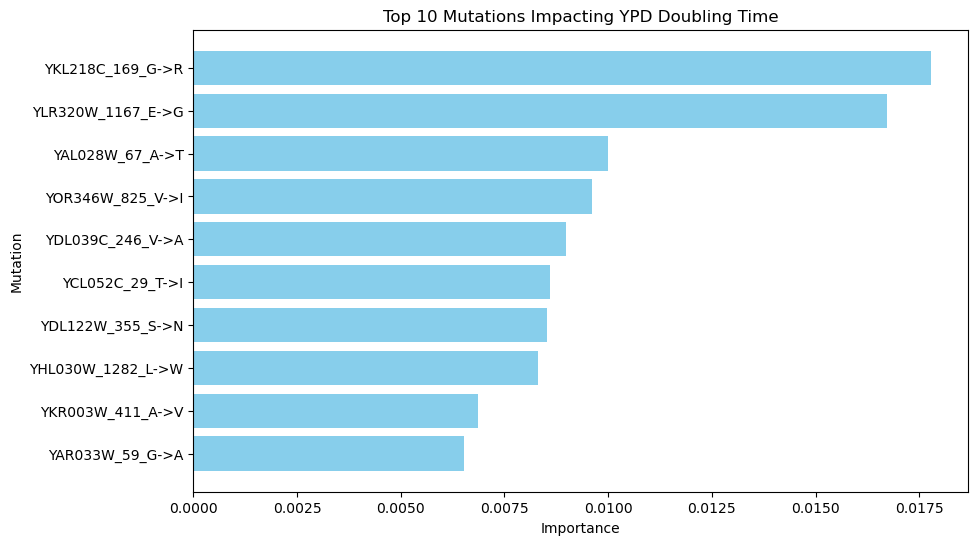

In [43]:
# Visualisation des résultats
print("Affichage des résultats...")
plt.figure(figsize=(10, 6))
plt.barh(top_mutations["Feature"], top_mutations["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Mutation")
plt.title("Top 10 Mutations Impacting YPD Doubling Time")
plt.gca().invert_yaxis()
plt.show()